## Credit Card Fraud Detection

In this project we will predict fraudulent credit card transactions with the help of Machine learning models.

In [ ]:
#import required libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#import data
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
df = pd.read_csv('/content/drive/My Drive/CapstoneData/creditcard.csv')

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploratory data analysis

In [ ]:
#observe the different feature type present in the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 29 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   V1             284807 non-null  float64
 1   V2             284807 non-null  float64
 2   V3             284807 non-null  float64
 3   V4             284807 non-null  float64
 4   V5             284807 non-null  float64
 5   V6             284807 non-null  float64
 6   V7             284807 non-null  float64
 7   V8             284807 non-null  float64
 8   V9             284807 non-null  float64
 9   V10            284807 non-null  float64
 10  V11            284807 non-null  float64
 11  V12            284807 non-null  float64
 12  V13            284807 non-null  float64
 13  V14            284807 non-null  float64
 14  V15            284807 non-null  float64
 15  V16            284807 non-null  float64
 16  V17            284807 non-null  float64
 17  V18            284807 non-nul

We see that all the data is numeric as the data is PCA transformed.

Here we will observe the distribution of our classes

In [ ]:
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100

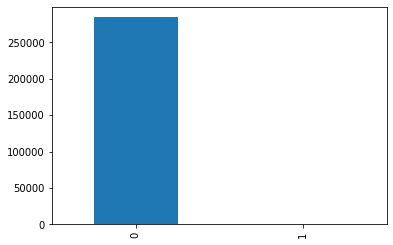

In [ ]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
df['Class'].value_counts().plot(kind='bar')

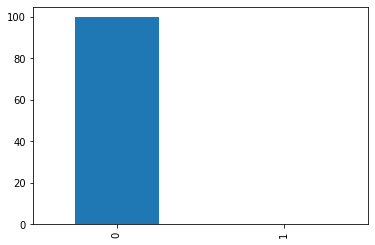

In [ ]:
(df['Class'].value_counts()/len(df['Class'])*100).plot(kind='bar')

We can see that there is a huge class imbalance and the amount of Class 1 records is almost negligble

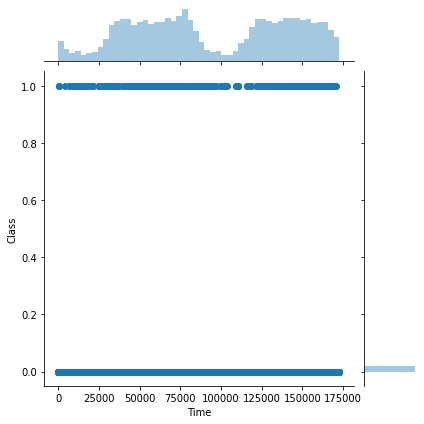

In [ ]:
# Create a scatter plot to observe the distribution of classes with time
sns.jointplot(x="Time", y="Class", data=df)

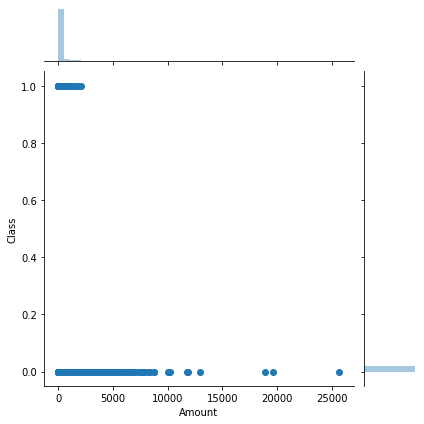

In [ ]:
# Create a scatter plot to observe the distribution of classes with Amount
sns.jointplot(x="Amount", y="Class", data=df)

One thing is clear that all the frauds have happened on lower amount transactions i.e <5000, however there is no clear pattern w.r.t time and we can potentially drop this for further modelling puposes.

In [ ]:
#creating a copy of the df before making changes in case needed for later use
df_copy = df[:]

# Drop unnecessary columns
df.drop(columns = ['Time'], inplace = True)

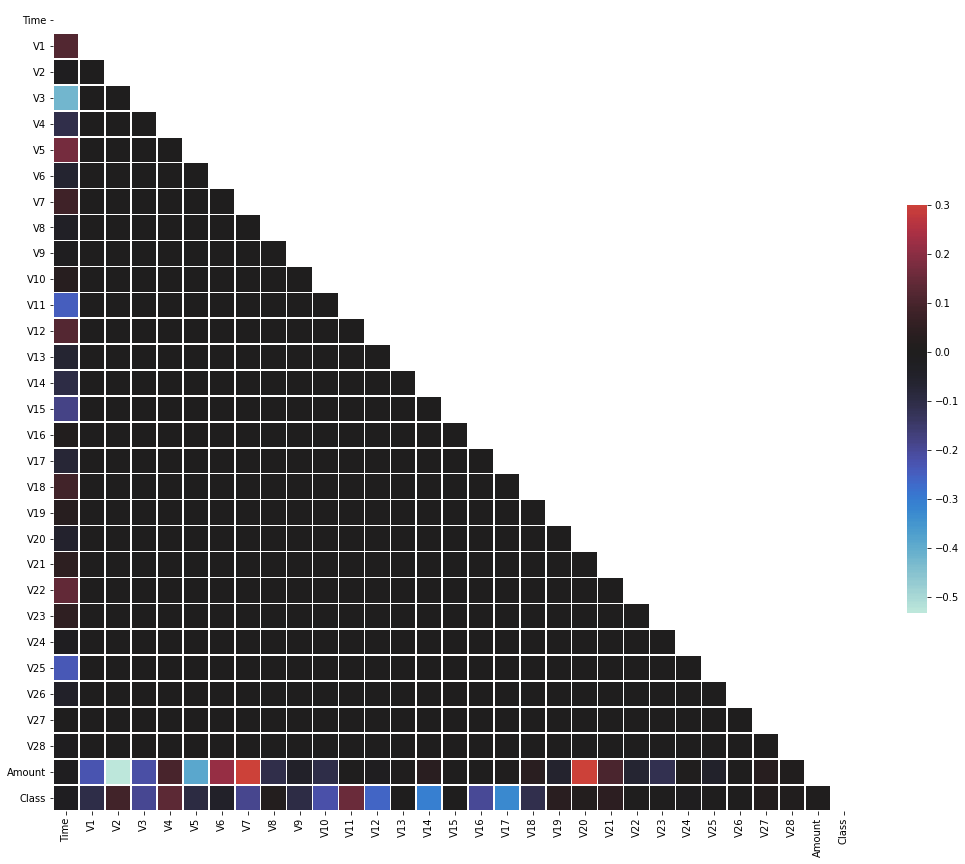

In [ ]:
#checking the correlation between the features. Since the data is PCA transformed, we not expect to see collinearity
corr = df_copy.corr()
hide = np.zeros_like(corr, dtype=np.bool)
hide[np.triu_indices_from(hide)] = True
f, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr, mask=hide, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# Calculate the VIFs for the features. Since the features are PCA transformed, expectation is that there must be minimal multicolliearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = df.columns
vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
28,Amount,5.44
1,V2,2.40
29,Class,2.09
6,V7,1.86
4,V5,1.73
19,V20,1.56
2,V3,1.28
0,V1,1.26
5,V6,1.23
16,V17,1.22


As expected, since the variables are already PCA transformed, the collinearity between the variables is very low and hence there is no redundancy in the features used in the model.

Checking for duplicates in the data:

In [ ]:
#this will mark all duplicates as true except for the first occurence
df[df.duplicated()]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
33,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,-0.484688,0.872490,0.851636,-0.571745,0.100974,-1.519772,-0.284376,-0.310524,-0.404248,-0.823374,-0.290348,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
35,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,-0.482474,0.871800,0.853447,-0.571822,0.102252,-1.519991,-0.285912,-0.309633,-0.403902,-0.823743,-0.283264,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
113,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,-0.243289,0.578063,0.674730,-0.534231,0.446601,1.122885,-1.768001,1.241157,-2.449500,-1.747255,-0.335520,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
114,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,-0.243289,0.578063,0.674730,-0.534231,0.446601,1.122885,-1.768001,1.241157,-2.449500,-1.747255,-0.335520,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
115,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,-0.243289,0.578063,0.674730,-0.534231,0.446601,1.122885,-1.768001,1.241157,-2.449500,-1.747255,-0.335520,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284708,2.018105,0.073226,-1.615154,0.351058,0.333905,-0.676284,0.050474,-0.071028,0.302728,-0.193920,1.206863,0.611617,-0.589935,-0.529698,-0.450015,0.483411,0.321520,0.192470,0.275352,-0.184898,-0.306646,-0.841768,0.356773,0.655112,-0.331463,0.144352,-0.069820,-0.039845,1.98,0
284751,2.050734,-0.364010,-2.542843,-0.729357,2.388455,3.318015,-0.479138,0.791559,0.403374,0.093232,0.004391,0.390166,-0.212555,0.495544,0.472633,-0.171595,-0.368261,-0.976572,0.022869,-0.154978,-0.293363,-0.834802,0.381740,0.698179,-0.264798,0.219275,-0.052131,-0.066940,0.89,0
284775,1.955547,-0.724606,-1.706511,-0.611145,1.710907,3.914215,-1.248690,1.054133,1.314064,-0.150553,-0.222844,0.496839,-0.050358,0.001067,0.894690,0.001418,-0.583473,0.075802,-0.359344,-0.137290,0.193605,0.690196,0.155951,0.726775,-0.061219,-0.192666,0.060347,-0.042323,12.99,0
284785,0.032887,0.545338,-1.185844,-1.729828,2.932315,3.401529,0.337434,0.925377,-0.165663,-0.386953,-0.199626,0.032017,-0.374731,0.354051,0.041228,-0.154750,-0.482455,-0.842462,-0.206385,0.022677,-0.266113,-0.716336,0.108519,0.688519,-0.460220,0.161939,0.265368,0.090245,1.79,0


We see that there are 9144 rows that are duplicates, and we can remove them to have cleaner data

In [ ]:
# making a boolean series 
bool_ser = df.duplicated()
  
# passing NOT of bool series to see unique values only 
df = df[~bool_ser] 
  
# displaying data 
df[df.duplicated()]
df.shape

(275663, 30)

We have gotten rid of all the dupliate data

### Splitting the data into train & test data

In [ ]:
y= df.pop('Class')

In [ ]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = train_test_split(df,y, train_size=0.7,test_size=0.3,random_state=100)

In [ ]:
#check the number of Class 1 (fraudulent) records in the test and train set
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

473
322
151


In [ ]:
print("Length of X_train is: {X_train}".format(X_train = len(X_train)))
print("Length of X_test is: {X_test}".format(X_test = len(X_test)))
print("Length of y_train is: {y_train}".format(y_train = len(y_train)))
print("Length of y_test is: {y_test}".format(y_test = len(y_test)))

Length of X_train is: 192964
Length of X_test is: 82699
Length of y_train is: 192964
Length of y_test is: 82699


### Feature Scaling 

In [ ]:
#import library for Normalization
from sklearn.preprocessing import StandardScaler

In [ ]:
#scaling the amount column in X_train
X_train['Amount_Scaled'] = StandardScaler().fit_transform(X_train['Amount'].values.reshape(-1,1))
X_train.drop(columns = ['Amount'], inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#scaling the amount column in X_test
X_test['Amount_Scaled'] = StandardScaler().fit_transform(X_test['Amount'].values.reshape(-1,1))
X_test.drop(columns = ['Amount'], inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_Scaled
201842,1.925666,-0.357053,-0.052040,0.620726,-0.912131,-0.741651,-0.531591,-0.129264,1.288207,-0.203868,-0.403037,1.189111,1.096128,-0.383155,0.375735,-0.166600,-0.351569,-0.098506,-0.499736,-0.160288,0.298485,1.171906,0.121732,0.464493,-0.083950,-0.181008,0.051074,-0.030301,-0.293155
269497,-0.653330,1.022734,2.051699,-0.337343,-0.134136,-0.412686,0.502622,0.029790,0.105595,-0.802657,-0.647326,0.338256,0.676784,-0.139758,1.242518,-0.202569,-0.367340,0.183080,0.700175,0.195830,-0.153678,-0.237697,-0.290537,0.018210,0.395488,-0.647802,0.360558,0.145522,-0.354884
114899,1.195931,0.710084,0.739169,2.471891,-0.072023,-0.505199,0.215095,-0.194995,-0.941258,0.647916,-0.289602,0.659695,1.463290,-0.004694,0.385502,0.650786,-0.723504,-0.477034,-1.014668,-0.066360,-0.058298,-0.136364,0.008758,0.409607,0.470790,-0.078760,0.001010,0.027166,-0.355717
35640,-2.159356,0.245967,1.478445,1.115763,-1.358313,0.499435,-0.330674,1.133209,-0.387292,-0.777013,0.170161,0.160848,-1.081795,0.739487,0.324795,0.581106,-0.098666,1.209136,0.963019,-0.232995,0.137044,0.194656,0.207151,-0.019388,0.318667,-0.254490,-0.076822,-0.363762,0.144456
68129,-1.273984,1.242461,1.322611,-1.397199,-0.373712,-1.440541,0.861133,-0.260478,0.901162,0.604015,-0.345026,-1.006582,-1.987168,-0.006924,0.644799,0.284977,-0.531640,-0.385428,-0.844927,0.331985,-0.177315,-0.226237,-0.038482,0.704004,-0.273362,0.720989,0.254849,0.140235,-0.340999


### Skewness Check

In [ ]:
#import library to get the skewness
import scipy.stats as st
print("Feature\t\tSkewness")
for i in X_train.columns:
  print(i, "\t\t", st.skew(X_train[i]))

Feature		Skewness
V1 		 -3.1979660260960983
V2 		 -4.538289429291202
V3 		 -2.0900323664854508
V4 		 0.6658938968487527
V5 		 -3.343404375889617
V6 		 2.1826510552716964
V7 		 4.1602989270651225
V8 		 -8.757056095508187
V9 		 0.539261571211442
V10 		 1.228640609580372
V11 		 0.33368245793648815
V12 		 -2.126236326119669
V13 		 0.0625447006835696
V14 		 -1.8705235893907333
V15 		 -0.29840901677340215
V16 		 -0.9783200989904255
V17 		 -3.550380597604742
V18 		 -0.225733340482668
V19 		 0.1253935324066412
V20 		 -2.8190500752429126
V21 		 2.459638214813681
V22 		 -0.18967134186826964
V23 		 -4.0727984719622485
V24 		 -0.5366940229422369
V25 		 -0.3595221825274526
V26 		 0.5930726632893175
V27 		 0.36832626952816966
V28 		 12.81804721022693
Amount_Scaled 		 17.364384273567


As a general rule of thumb: If skewness is less than -1 or greater than 1, the distribution is highly skewed. If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed. If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

And by this rule features  V1, V2, V3, V6, V7, V8, V10, V12, V14, V16, V17, V20, V21, V23, V27, V28, Amount are all highly skewed.

In [ ]:
skw = ['V1', 'V2', 'V3', 'V6', 'V7', 'V8', 'V10', 'V12', 'V14', 'V16', 'V17', 'V21', 'V23', 'V27', 'V28', 'Amount_Scaled']

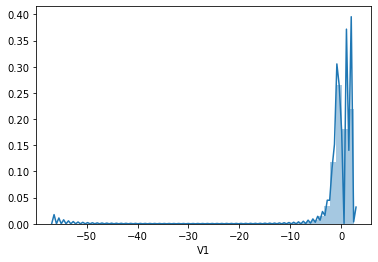

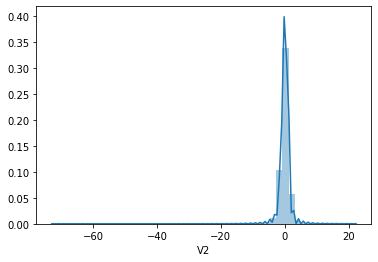

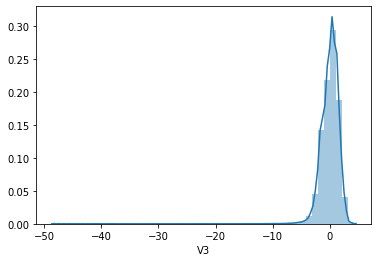

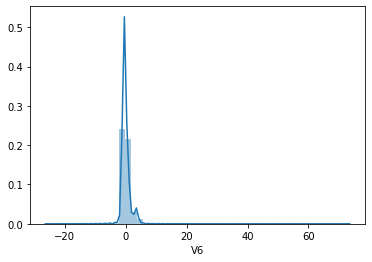

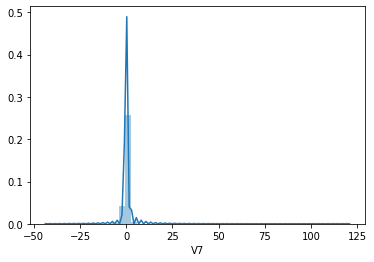

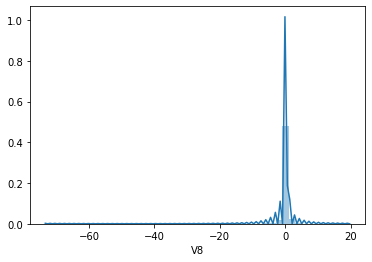

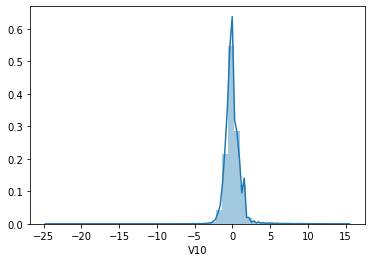

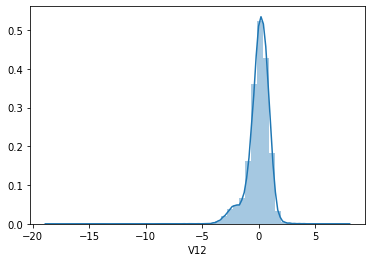

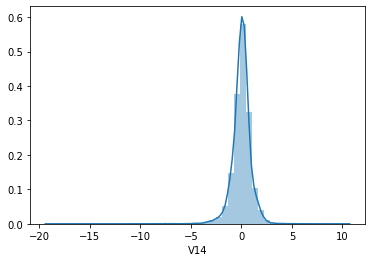

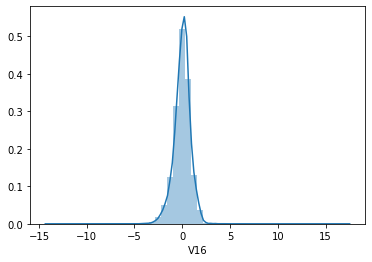

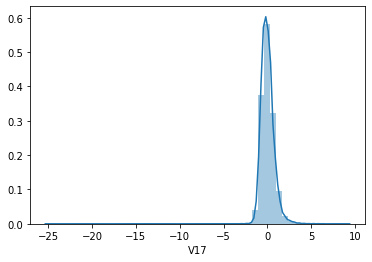

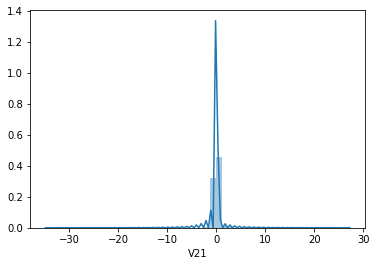

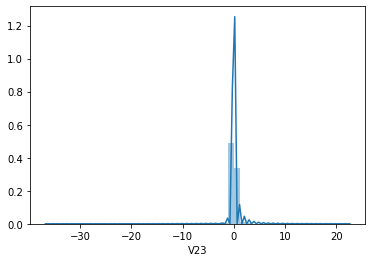

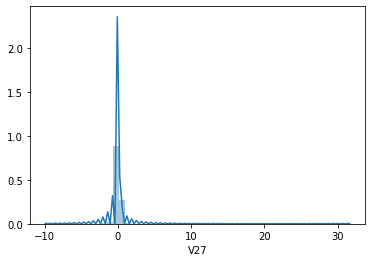

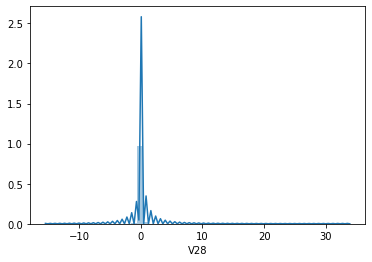

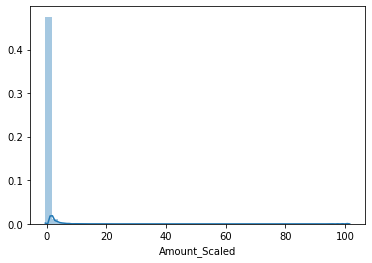

In [ ]:
#plotting histogram of faetures which are skewed

for i in skw:
  plt.figure()
  sns.distplot(X_train[i])

If there is skewness present in the distribution use:
Power Transformer package present in the preprocessing library provided by sklearn to make distribution more gaussian

We will remove the skewness by transofrming the data using PowerTransformer

In [ ]:
# import library required for removing skewness. Power Transformer uses the Yeo-Johnson transform
from sklearn.preprocessing import PowerTransformer

In [ ]:
pt = PowerTransformer()
pt.fit(X_train)                       ## Fit the PT on training data
X_train_pt = pd.DataFrame(pt.transform(X_train))

In [ ]:
X_train_pt.columns = X_train.columns

In [ ]:
# Checking the skewness again

print("Feature\t\tSkewness")
for i in X_train_pt.columns:
  #print(i, "\t\t", st.skew(X_train[i]))
  print(i, "\t\t", st.skew(X_train_pt[i]))

Feature		Skewness
V1 		 -0.2161191674468003
V2 		 0.3230082638419292
V3 		 -0.0762221767402719
V4 		 0.015025619528749604
V5 		 -1.4981029959425236
V6 		 -1.7866361458484004
V7 		 2.735395619799945
V8 		 2.175377489219516
V9 		 -0.058331447375455044
V10 		 -1.3072778162135177
V11 		 0.05964256040656993
V12 		 0.15713937492725374
V13 		 0.007199563298682592
V14 		 0.0881176426621479
V15 		 0.014289251966360847
V16 		 0.1673398888227886
V17 		 -0.8135929783047025
V18 		 -0.05305260531873384
V19 		 0.012779587846409425
V20 		 -0.9924279383059552
V21 		 -1.9748667885616704
V22 		 -0.008062979554288583
V23 		 -0.2560824389020583
V24 		 0.13121996028097385
V25 		 0.08423115121627352
V26 		 -0.025265875775884707
V27 		 3.5260030146272943
V28 		 0.853407635080604
Amount_Scaled 		 0.6950251830806993


We can see that after applying power transformer, the feature skewness is drastically reduced and now can be used for modelling. Before modelling, we will transform the test data also with the same transformer

In [ ]:
#transforming test data with power transformer
X_test_pt = pd.DataFrame(pt.transform(X_test))
X_test_pt.columns = X_test.columns

## Model Building
- Build different models on the imbalanced dataset and see the result:
We will be building - 
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. XGBoost

In [ ]:
# Import libraries to run our models
from sklearn import linear_model #import the package
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

#### Logistic Regression

In [ ]:
logistic = LogisticRegression()

# create pipeline
steps = [("scaler", StandardScaler()), 
         ("logistic", logistic)
        ]

# compile pipeline
pca_logistic = Pipeline(steps)

# hyperparameter space
params = {'logistic__C': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=pca_logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [ ]:
# fit model
model.fit(X_train_pt,y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  2.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logistic',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                  

In [ ]:
# cross validation results
pd.DataFrame(model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.219221,0.030534,0.000000,0.000000,0.0001,l1,"{'logistic__C': 0.0001, 'logistic__penalty': '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,56
1,0.869921,0.045119,0.034849,0.004278,0.0001,l2,"{'logistic__C': 0.0001, 'logistic__penalty': '...",0.946820,0.942996,0.960412,0.928636,0.970001,0.949773,0.014309,28
2,0.177034,0.003253,0.000000,0.000000,0.001,l1,"{'logistic__C': 0.001, 'logistic__penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,31
3,0.923930,0.055706,0.034781,0.002398,0.001,l2,"{'logistic__C': 0.001, 'logistic__penalty': 'l2'}",0.981711,0.966220,0.988827,0.970594,0.994143,0.980299,0.010572,27
4,0.173133,0.006002,0.000000,0.000000,0.01,l1,"{'logistic__C': 0.01, 'logistic__penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,34
5,1.259694,0.044378,0.034145,0.002367,0.01,l2,"{'logistic__C': 0.01, 'logistic__penalty': 'l2'}",0.984640,0.978260,0.986682,0.978653,0.993322,0.984311,0.005578,1
6,0.171817,0.005235,0.000000,0.000000,0.05,l1,"{'logistic__C': 0.05, 'logistic__penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
7,1.614014,0.052678,0.032665,0.001483,0.05,l2,"{'logistic__C': 0.05, 'logistic__penalty': 'l2'}",0.981167,0.978209,0.984633,0.980018,0.988878,0.982581,0.003783,2
8,0.173308,0.001576,0.000000,0.000000,0.1,l1,"{'logistic__C': 0.1, 'logistic__penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,38
9,1.698775,0.070089,0.034228,0.002217,0.1,l2,"{'logistic__C': 0.1, 'logistic__penalty': 'l2'}",0.980014,0.977553,0.984127,0.980109,0.987035,0.981768,0.003373,3


In [ ]:
#print best hyperparameters
print("Best roc_auc: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best roc_auc:  0.9843113428284967
Best hyperparameters:  {'logistic__C': 0.01, 'logistic__penalty': 'l2'}


For model evaluation purposes, we have chosen AUC_ROC and not the accuracy due to the high class imbalance.

We will not be running KNN and SVM as our data set is larger than the recommended size for these 2 models and will take very long time to execute

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# RANDOM FOREST :

forest = RandomForestClassifier(n_jobs = -1)

# hyperparameter space
params = {"criterion": ['gini', 'entropy'], "max_features": ['auto', 0.4]}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model1 = GridSearchCV(estimator=forest, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [ ]:
# fit model
model1.fit(X_train_pt, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 48.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              o

In [ ]:
#print best hyperparameters
print("Best roc_auc: ", model1.best_score_)
print("Best hyperparameters: ", model1.best_params_)

Best roc_auc:  0.9543233207190529
Best hyperparameters:  {'criterion': 'entropy', 'max_features': 'auto'}


#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# DECISION TREE :

dtc = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

model2 = GridSearchCV(estimator=dtc, param_grid=parameter_grid, cv=cross_validation, scoring='roc_auc' , n_jobs=-1, verbose=1)

In [ ]:
# fit model
model2.fit(X_train_pt, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
           

In [ ]:
#print best hyperparameters
print("Best roc_auc: ", model2.best_score_)
print("Best hyperparameters: ", model2.best_params_)

Best roc_auc:  0.9317530451525823
Best hyperparameters:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 4, 'splitter': 'best'}


#### XGBoost

In [ ]:
fimport xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
# XGBoost :

xg = XGBClassifier()

param_grid = {'learning_rate': [0.1, 0.2 , 0.4],
              'subsample': [0.3, 0.6, 0.8],
              'n_estimators' : range(2, 30, 5),
              'max_depth' : [2, 4]
             }

cross_validation = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

model3 = GridSearchCV(estimator=xg, param_grid=param_grid, cv=cross_validation, scoring='roc_auc' , n_jobs=-1, verbose=1)

In [ ]:
# fit model
model3.fit(X_train_pt, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 36.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.4], 'max_depth': [2, 4],
                         'n_es

In [ ]:
#print best hyperparameters
print("Best roc_auc: ", model3.best_score_)
print("Best hyperparameters: ", model3.best_params_)

Best roc_auc:  0.9820719889344776
Best hyperparameters:  {'learning_rate': 0.4, 'max_depth': 2, 'n_estimators': 27, 'subsample': 0.8}


#### Proceed with the model which shows the best result 

Model with the highest AUC_ROC i.e 0.98 is XGBoot and will we create an XGBoost model with the best parameters and verify on the test set.

In [ ]:
# XGBoost with optimum hyperparameters :

clf = XGBClassifier()

param_grid = {'learning_rate': [0.4],
              'subsample': [0.8],
              'n_estimators' : [27],
              'max_depth' : [2]
             }

cross_validation = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

model4 = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cross_validation, scoring='roc_auc' , n_jobs=-1, verbose=1)

In [ ]:
# fit model
fit = model4.fit(X_train_pt, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.4s finished


In [ ]:
#ROC_AUC
print("Best roc_auc: ", model4.best_score_)

Best roc_auc:  0.9691291899620931


Prediction on TEST Data :

In [ ]:
#Confusion Matrix :
y_pred = model4.predict(X_test_pt)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[82531    17]
 [   25   126]]


In [ ]:
from imblearn.metrics import sensitivity_specificity_support

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [ ]:
# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

Sensitivity: 	0.83
Specificity: 	1.0


In [ ]:
from sklearn.metrics import recall_score

In [ ]:
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)

Recall: 0.834437


In [ ]:
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
import sklearn

In [ ]:
# roc_auc
auc = sklearn.metrics.roc_auc_score(y_test, y_pred)
auc

0.9171155726533742

We see that since the data is imbalanced the Test AUC_ROC score is much lesser (0.91) when compared to the train AUC-ROC (0.96)

### Print the important features of the best model to understand the dataset
- This will not give much explanation on the already transformed dataset
- But it will help us in understanding if the dataset is not PCA transformed

In [ ]:
model4.best_estimator_.feature_importances_

array([0.        , 0.        , 0.01633827, 0.03643509, 0.00166715,
       0.        , 0.0435136 , 0.02822546, 0.01953079, 0.09397413,
       0.        , 0.10776628, 0.02139489, 0.08803397, 0.03082698,
       0.02195895, 0.24082151, 0.02843165, 0.        , 0.03552683,
       0.01634837, 0.01259562, 0.024759  , 0.        , 0.        ,
       0.04574636, 0.03618939, 0.02787572, 0.02203992], dtype=float32)

Top var = 17
2nd Top var = 12
3rd Top var = 10


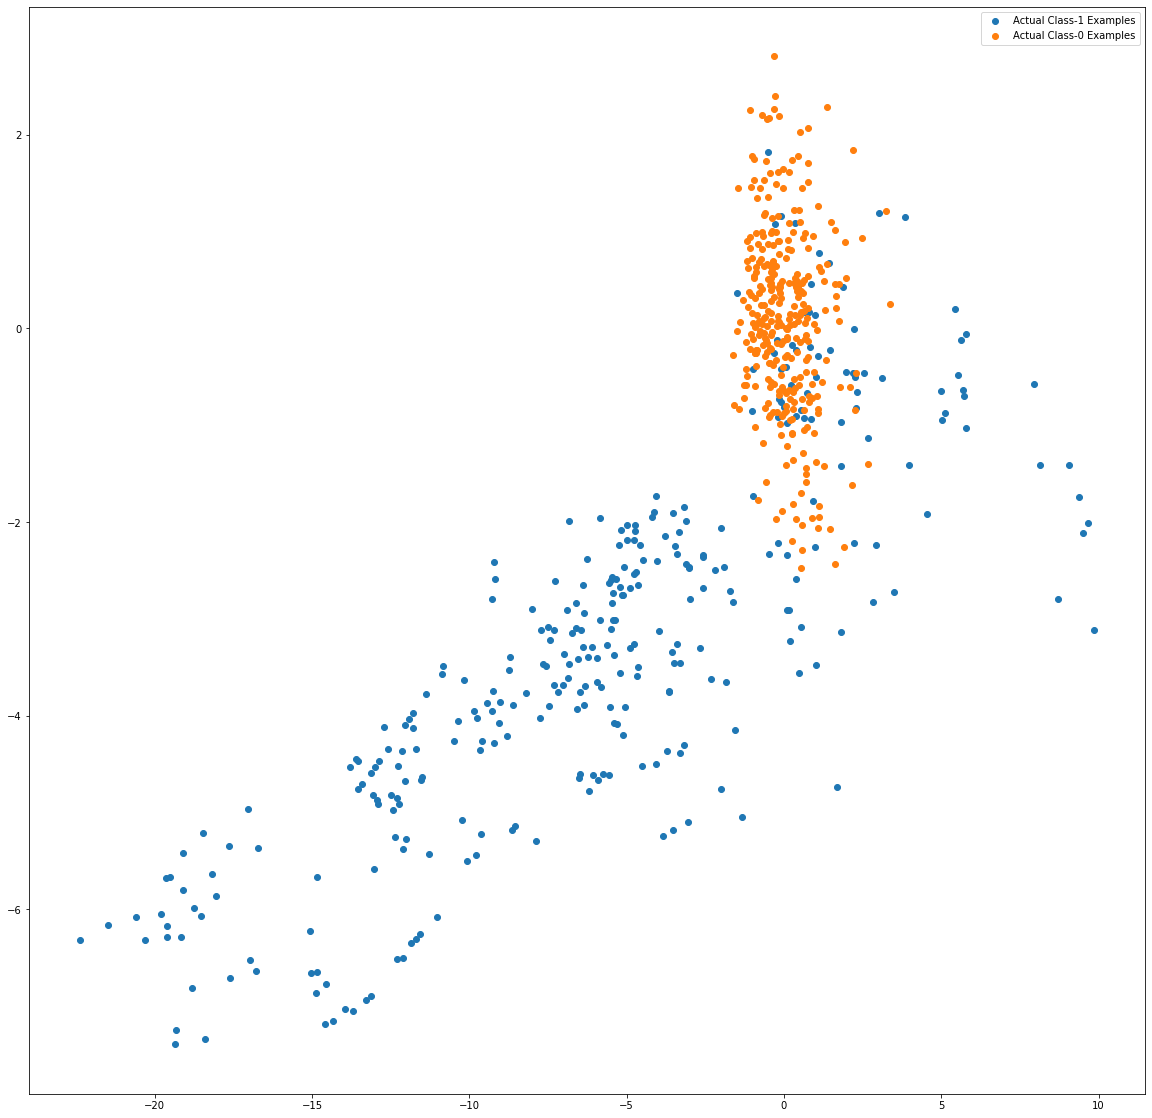

In [ ]:
var_imp = []
for i in model4.best_estimator_.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(model4.best_estimator_.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(model4.best_estimator_.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(model4.best_estimator_.feature_importances_)[-3])+1)

# Variable on Index-16 and Index-13 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(model4.best_estimator_.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(model4.best_estimator_.feature_importances_)[-2])

X_train_1 = X_train_pt.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train_pt.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

## Model building with balanced Classes

##### We will perform class balancing with :
- SMOTE
- ADASYN

## Model Building
- Build different models on the balanced dataset and see the result
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. XGBoost

### Print the class distribution after applying SMOTE 

In [ ]:
from imblearn import over_sampling

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


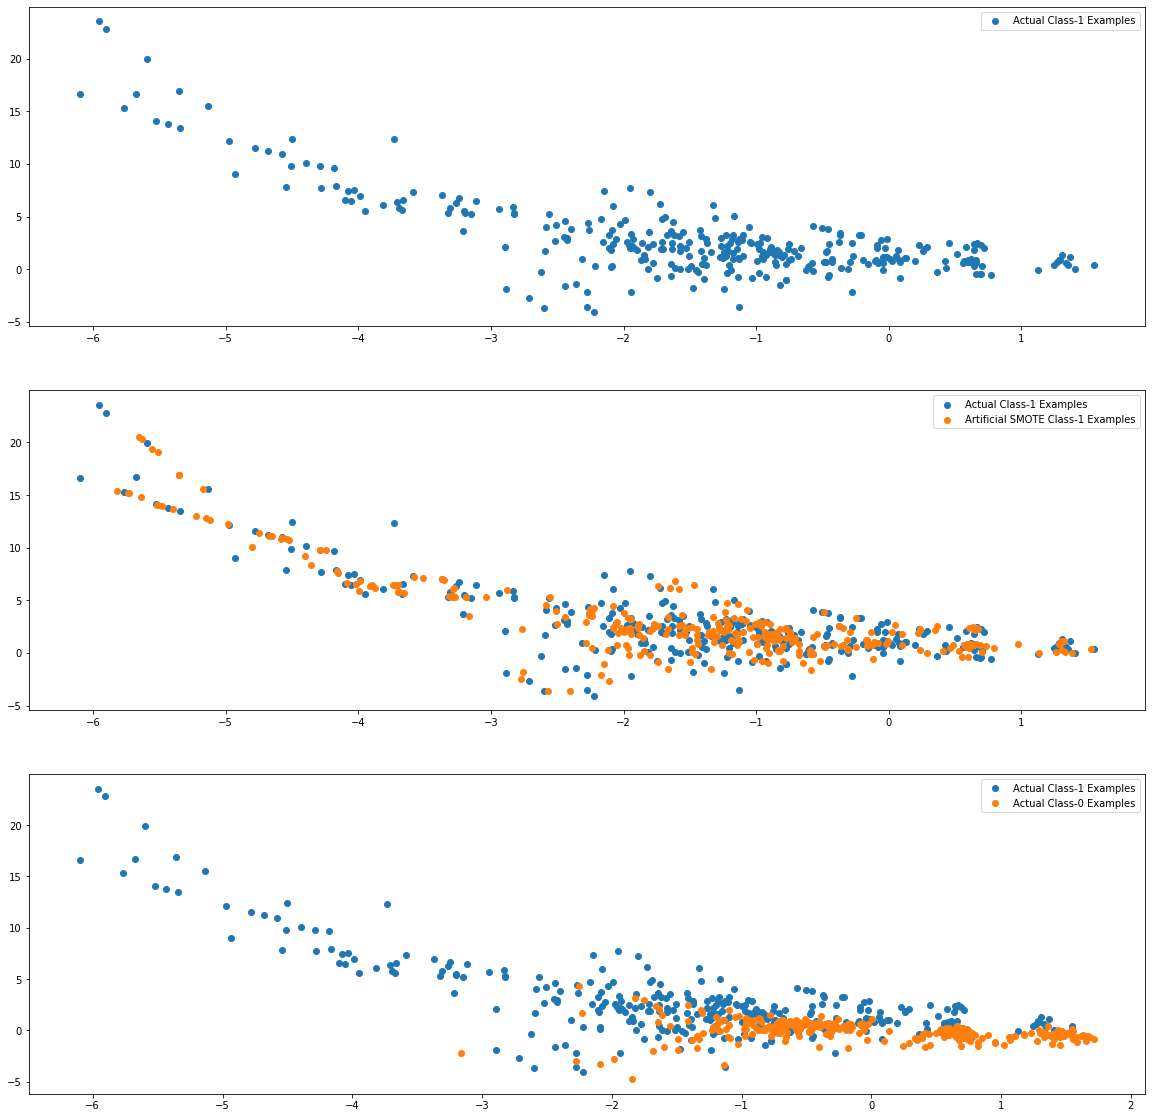

In [ ]:
import warnings
warnings.filterwarnings("ignore")


sm = over_sampling.SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_resample(X_train_pt, y_train)
# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_smote_1 = X_train_smote[X_train_pt.shape[0]:]

X_train_1 = X_train_pt.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train_pt.to_numpy()[np.where(y_train==0.0)]


plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_smote_1[:X_train_1.shape[0], 0], X_train_smote_1[:X_train_1.shape[0], 1],
            label='Artificial SMOTE Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

In [ ]:
print('Shape of X_train_smote_1 which is the actual Artificial Minority Samples from SMOTE :',X_train_smote_1.shape)
print('Shape of X_train_smote :',X_train_smote.shape)
print('Shape of y_train_smote :',y_train_smote.shape)

Shape of X_train_smote_1 which is the actual Artificial Minority Samples from SMOTE : (192320, 29)
Shape of X_train_smote : (385284, 29)
Shape of y_train_smote : (385284,)


#### Logistic Regression with SMOTE

In [ ]:
# logistic regression 
logistic = LogisticRegression()

# create pipeline
steps = [("scaler", StandardScaler()), 
         ("logistic", logistic)
        ]

# compile pipeline
pca_logistic = Pipeline(steps)

# hyperparameter space
params = {'logistic__C': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model_lr_smote = GridSearchCV(estimator=pca_logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [ ]:
# fit model
model_lr_smote.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  7.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logistic',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                  

In [ ]:
#print best hyperparameters
print("Best roc_auc: ", model_lr_smote.best_score_)
print("Best hyperparameters: ", model_lr_smote.best_params_)

Best roc_auc:  0.9871766244437552
Best hyperparameters:  {'logistic__C': 1000, 'logistic__penalty': 'l2'}


#### Decision Tree with SMOTE

In [ ]:
# DECISION TREE :

dtc = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

model5 = GridSearchCV(estimator=dtc, param_grid=parameter_grid, cv=cross_validation, scoring='roc_auc' , n_jobs=-1, verbose=1)

In [ ]:
# fit model
model5.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
           

In [ ]:
#print best hyperparameters
print("Best roc_auc: ", model5.best_score_)
print("Best hyperparameters: ", model5.best_params_)

Best roc_auc:  0.9703968806275608
Best hyperparameters:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 4, 'splitter': 'best'}


Before SMOTE, ROC_AUC for Decision Tree : 0.93 

After SMOTE, ROC_AUC for Decision Tree : 0.97

#### Random Forest with SMOTE

In [ ]:
# RANDOM FOREST :

forest = RandomForestClassifier(n_jobs = -1)

# hyperparameter space
params = {'criterion': ['gini', 'entropy'], 
          'max_features': ['auto', 0.4],
          'n_estimators': [30,35],
          'max_depth': [8, 15]}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model6 = GridSearchCV(estimator=forest, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [ ]:
# fit model
model6.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 55.1min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 110.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              o

In [ ]:
#print best hyperparameters
print("Best roc_auc: ", model6.best_score_)
print("Best hyperparameters: ", model6.best_params_)

Best roc_auc:  0.9999915602547038
Best hyperparameters:  {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 30}


#### XGBoost with SMOTE

In [ ]:
# XGBoost :

xg = XGBClassifier()

param_grid = {'learning_rate': [0.1, 0.2 , 0.4],
              'subsample': [0.3, 0.6, 0.8],
              'n_estimators' : range(2, 30, 5),
              'max_depth' : [2, 4]
             }

cross_validation = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

model7 = GridSearchCV(estimator=xg, param_grid=param_grid, cv=cross_validation, scoring='roc_auc' , n_jobs=-1, verbose=1)

In [ ]:
# fit model
model7.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 62.6min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 80.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.4], 'max_depth': [2, 4],
                         'n_es

In [ ]:
#print best hyperparameters
print("Best roc_auc: ", model7.best_score_)
print("Best hyperparameters: ", model7.best_params_)

Best roc_auc:  0.9996554191293467
Best hyperparameters:  {'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 27, 'subsample': 0.8}


### Print the class distribution after applying ADASYN

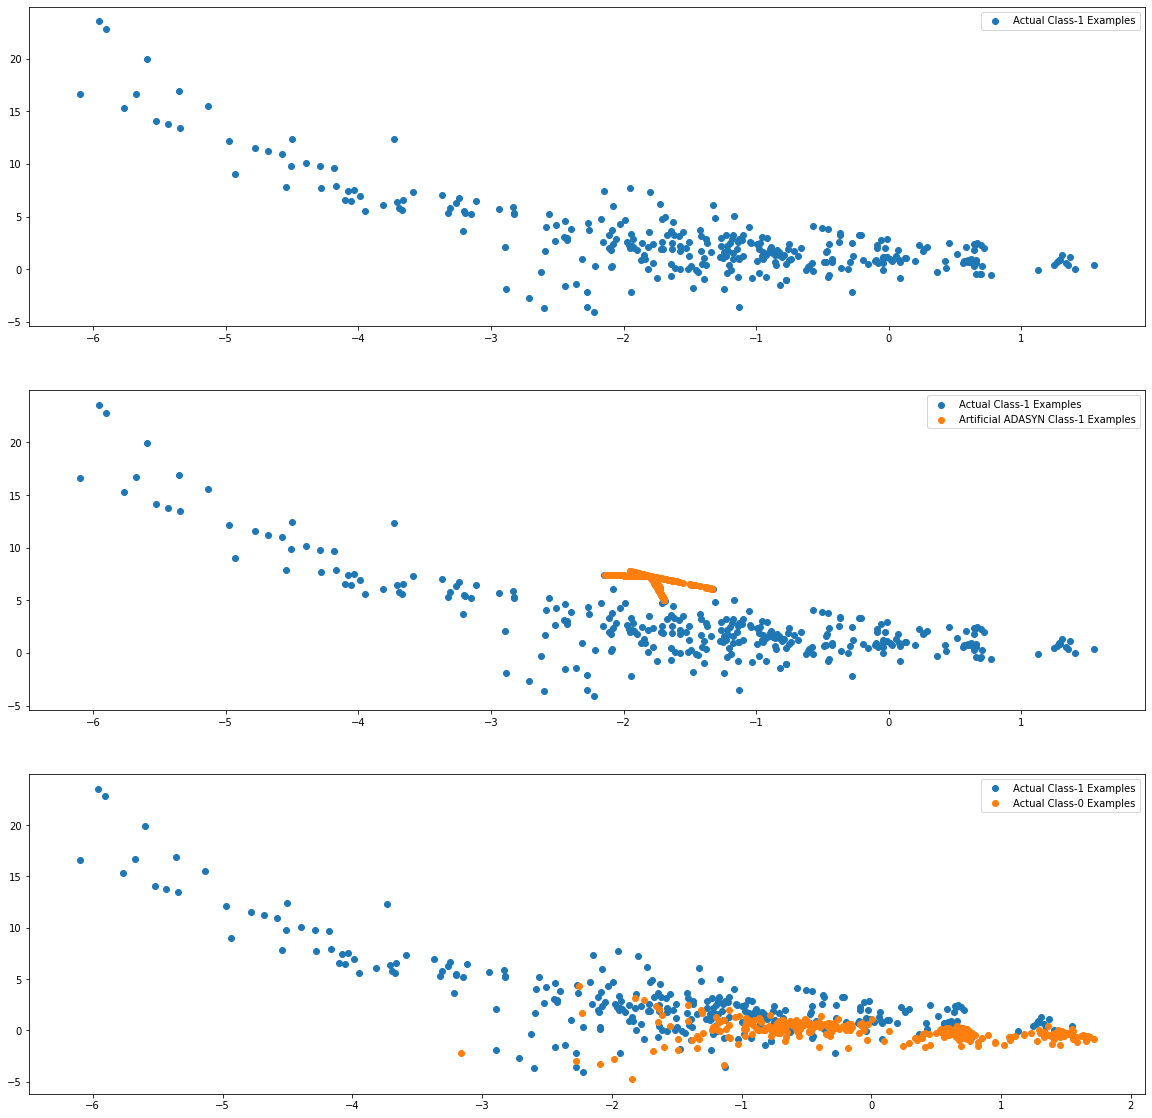

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from imblearn import over_sampling

ada = over_sampling.ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train_pt, y_train)
# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_adasyn[X_train_pt.shape[0]:]

X_train_1 = X_train_pt.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train_pt.to_numpy()[np.where(y_train==0.0)]



import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_adasyn_1[:X_train_1.shape[0], 0], X_train_adasyn_1[:X_train_1.shape[0], 1],
            label='Artificial ADASYN Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

In [ ]:
print('Shape of X_train_adasyn_1 which is the actual Artificial Minority Samples from SMOTE :',X_train_adasyn_1.shape)
print('Shape of X_train_adasyn :',X_train_adasyn.shape)
print('Shape of y_train_adasyn :',y_train_adasyn.shape)

Shape of X_train_adasyn_1 which is the actual Artificial Minority Samples from SMOTE : (192319, 29)
Shape of X_train_adasyn : (385283, 29)
Shape of y_train_adasyn : (385283,)


#### Logistic Regression with ADASYN

In [ ]:
# logistic regression 
logistic = LogisticRegression()

# create pipeline
steps = [("scaler", StandardScaler()), 
         ("logistic", logistic)
        ]

# compile pipeline
pca_logistic = Pipeline(steps)

# hyperparameter space
params = {'logistic__C': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model_lr_adasyn = GridSearchCV(estimator=pca_logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [ ]:
# fit model
model_lr_adasyn.fit(X_train_adasyn, y_train_adasyn)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  6.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logistic',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                  

In [ ]:
#print best hyperparameters
print("Best roc_auc: ", model_lr_adasyn.best_score_)
print("Best hyperparameters: ", model_lr_adasyn.best_params_)

Best roc_auc:  0.9610321435770199
Best hyperparameters:  {'logistic__C': 1000, 'logistic__penalty': 'l2'}


#### Decision Tree with ADASYN

In [ ]:
# DECISION TREE :

dtc = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

model8 = GridSearchCV(estimator=dtc, param_grid=parameter_grid, cv=cross_validation, scoring='roc_auc' , n_jobs=-1, verbose=1)

In [ ]:
# fit model
model8.fit(X_train_adasyn, y_train_adasyn)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.1min finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
           

In [ ]:
#print best hyperparameters
print("Best roc_auc: ", model8.best_score_)
print("Best hyperparameters: ", model8.best_params_)

Best roc_auc:  0.9259494994965038
Best hyperparameters:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 4, 'splitter': 'best'}


#### Random Forest with ADASYN

In [ ]:
# RANDOM FOREST :

forest = RandomForestClassifier(n_jobs = -1)

# hyperparameter space
params = {'criterion': ['gini', 'entropy'], 
          'max_features': ['auto', 0.4],
          'n_estimators': [30,35],
          'max_depth': [8, 15]}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model9 = GridSearchCV(estimator=forest, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [ ]:
# fit model
model9.fit(X_train_adasyn, y_train_adasyn)# fit model
model9.fit(X_train_adasyn, y_train_adasyn)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 50.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 108.0min finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 52.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 109.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              o

In [ ]:
#print best hyperparameters
print("Best roc_auc: ", model9.best_score_)
print("Best hyperparameters: ", model9.best_params_)

Best roc_auc:  0.9999893825950034
Best hyperparameters:  {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 35}


#### XGBoost with ADASYN

In [ ]:
# XG BOOST :

xg = XGBClassifier()

param_grid = {'learning_rate': [0.1, 0.2 , 0.4],
              'subsample': [0.3, 0.6, 0.8],
              'n_estimators' : range(2, 30, 5),
              'max_depth' : [2, 4]
             }

cross_validation = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

model10 = GridSearchCV(estimator=xg, param_grid=param_grid, cv=cross_validation, scoring='roc_auc' , n_jobs=-1, verbose=1)

In [ ]:
# fit model
model10.fit(X_train_adasyn, y_train_adasyn)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 57.9min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 75.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.4], 'max_depth': [2, 4],
                         'n_es

In [ ]:
#print best hyperparameters
print("Best roc_auc: ", model10.best_score_)
print("Best hyperparameters: ", model10.best_params_)

Best roc_auc:  0.9992259424493041
Best hyperparameters:  {'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 27, 'subsample': 0.6}


### Select the oversampling method which shows the best result on a model
- Apply the best hyperparameter on the model
- Predict on the test dataset

We have the below table which collates results from all the models built along with the oversampling techniques used

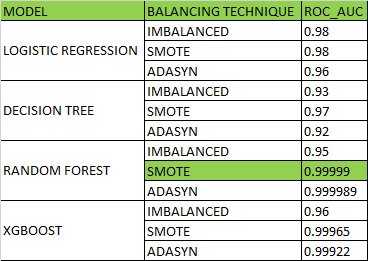

Seems like the best model giving the highest ROC_AUC score is :
RANDOM FOREST with SMOTE 

##### Best Model - Random Forest with SMOTE

In [ ]:
# RANDOM FOREST USING SMOTE WITH BEST HYPERPARAMETERS - FINAL MODEL :


forest = RandomForestClassifier(n_jobs = -1)

# hyperparameter space
params = {'criterion': ['entropy'], 
          'max_features': ['auto'],
          'n_estimators': [30],
          'max_depth': [15]}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model_final = GridSearchCV(estimator=forest, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [ ]:
# fit model
model_final.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              o

In [ ]:
#ROC_AUC :
print("Best roc_auc: ", model_final.best_score_)

Best roc_auc:  0.9999922195505629


#### Predict on Test Data :

In [ ]:
#Confusion Matrix :
y_pred_final = model_final.predict(X_test_pt)

# create onfusion matrix
cm_final = confusion_matrix(y_test, y_pred_final)
print(cm_final)

[[82489    59]
 [   19   132]]


In [ ]:
# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred_final, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

Sensitivity: 	0.87
Specificity: 	1.0


In [ ]:
recall_final = recall_score(y_test, y_pred_final)
print('Recall: %f' % recall_final)

Recall: 0.874172


In [ ]:
y_pred_final[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# ROC_AUC : 
auc_final = sklearn.metrics.roc_auc_score(y_test, y_pred_final)
auc_final

0.9367287248807599

ROC_AUC score from RANDOM FOREST using SMOTE in TRAINING DATASET : 0.99999

ROC_AUC score from RANDOM FOREST using SMOTE in TEST DATASET : 0.93672

### Print the important features of the best model to understand the dataset

In [ ]:
model_final.best_estimator_.feature_importances_

array([0.01218302, 0.033093  , 0.02911986, 0.0911156 , 0.01040935,
       0.0149565 , 0.05658368, 0.02470118, 0.02820712, 0.15566125,
       0.0664232 , 0.0732914 , 0.0082718 , 0.10740092, 0.00639044,
       0.06511056, 0.08306372, 0.01804806, 0.01767016, 0.01255239,
       0.01783834, 0.00662317, 0.00764303, 0.00471462, 0.00608541,
       0.00682438, 0.01614721, 0.00969638, 0.01017426])

Top var = 10
2nd Top var = 14
3rd Top var = 4


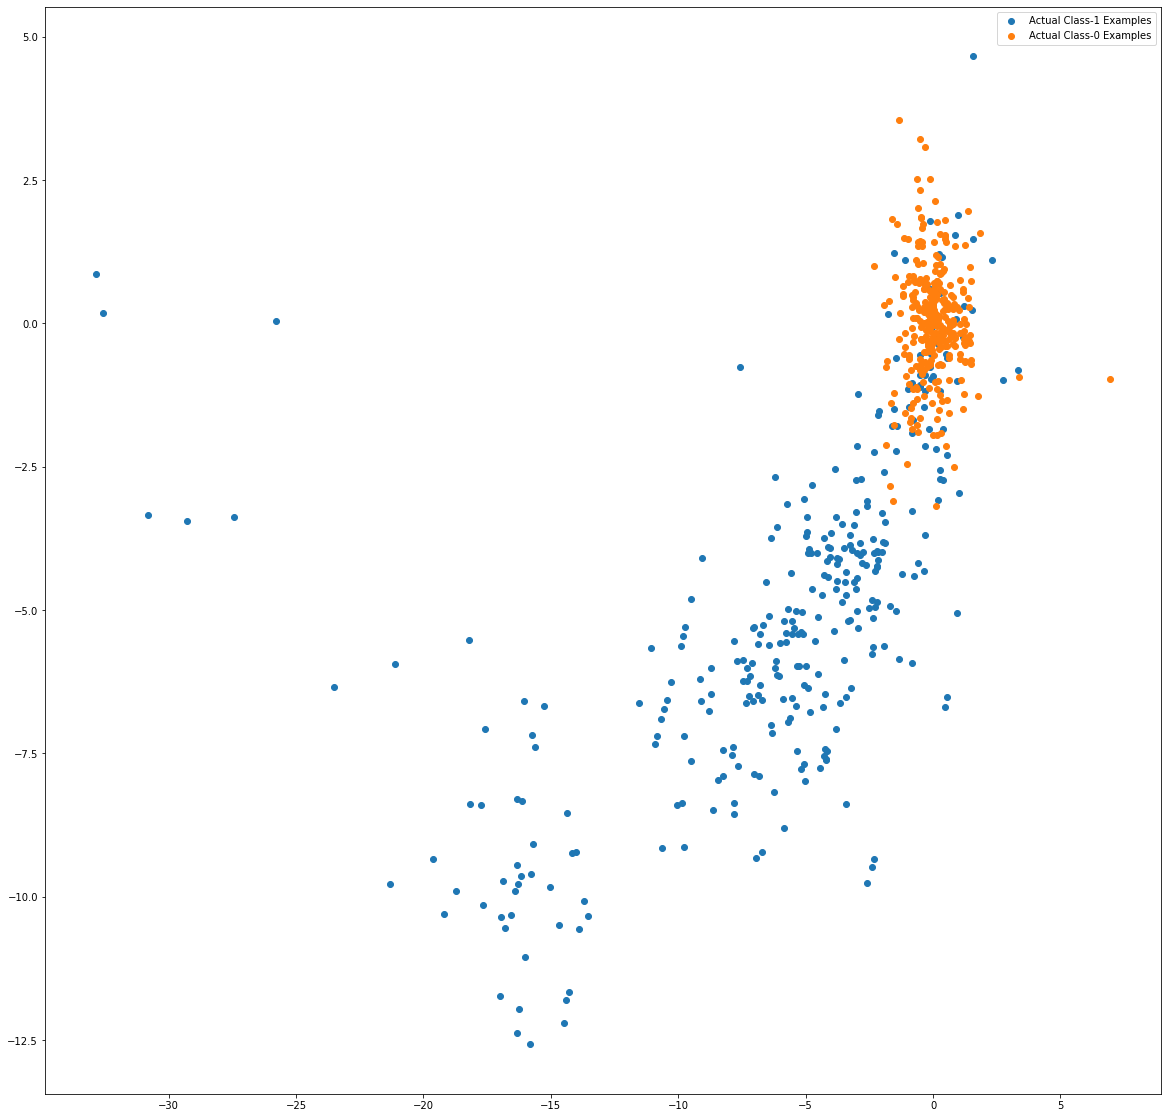

In [ ]:
var_imp = []
for i in model_final.best_estimator_.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(model_final.best_estimator_.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(model_final.best_estimator_.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(model_final.best_estimator_.feature_importances_)[-3])+1)

# Variable on Index-13 and Index-9 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(model_final.best_estimator_.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(model_final.best_estimator_.feature_importances_)[-2])

X_train_1 = X_train_pt.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train_pt.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

In [ ]:
#### Print the FPR,TPR & select the best threshold from the roc curve

In [ ]:
print('Train auc =', metrics.roc_auc_score(y_test, y_pred_final))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_final)
threshold = thresholds[np.argmax(tpr-fpr)]
print(threshold)

Train auc = 0.9367287248807599
1
